# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import re

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import spacy
!python -m spacy download en_core_web_sm-q


[x] No compatible package found for 'en_core_web_sm-q' (spaCy v3.2.1)



In [2]:
tweets = pd.read_csv('train.csv')

### Exploring and cleaning the dataset

In [3]:
tweets.describe(include = 'all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [4]:
#Deleting duplicated tweets.
tweets.drop_duplicates('text', keep = 'first', inplace = True)
tweets.describe(include = 'all')

,id,keyword,location,text,target
count,7503.000000,7447,5021,7503,7503.000000
unique,NaN,221,3327,7503,NaN
top,NaN,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,NaN
freq,NaN,45,104,1,NaN
mean,5439.831401,NaN,NaN,NaN,0.426230
std,3141.748725,NaN,NaN,NaN,0.494561
min,1.000000,NaN,NaN,NaN,0.000000
25%,2726.500000,NaN,NaN,NaN,0.000000
50%,5408.000000,NaN,NaN,NaN,0.000000
75%,8149.500000,NaN,NaN,NaN,1.000000


In [5]:
#We'll use a simple detaset to determine if a tweet is about a real disaster or not.
#To do so, we'll only keep 'text' and 'target' columns

tweets_clean = tweets.loc[:,['text', 'target']]

In [6]:
tweets_clean

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1
7605,on the flip side I'm at Walmart and there is a...,1
7606,Suicide bomber kills 15 in Saudi security site...,1
7608,Two giant cranes holding a bridge collapse int...,1


### Preprocessing tweets

In [7]:
#Importing STOPWORDS and Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

In [8]:
#As we can see, our tweets are relatively clean, no Usernames, emojis etc...
#We'll proceed to a quick cleaning to be sure.

def cleaning(text):
    text = re.sub( r'(^|[^@\w])@(\w{1,15})\b', '',text) #Twitter Usernames    
    text = re.sub('rt', '', text)# 'Retweets'
    text = re.sub('[0-9]', ' ', text) #Spaces
    text = re.sub(' +', ' ', text) #Spaces
    text = re.sub('[#$%&?,!()*+-/:;<=>@]', '', text) #Punctuation
    text = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', text) #caractères spéciaux
    text = re.sub(r'http\S+', '', text).lower().strip() #URLs
    return text

tweets_clean['text_clean'] = tweets_clean['text'].apply(lambda x : cleaning(x))

#Lemmatizing and deleting stop words

def lemmatize_sw(text):
    text = nlp(text)
    text = ' '.join([token.lemma_ for token in text if token.text not in STOP_WORDS])
    return text

tweets_clean['text_lemma'] = tweets_clean['text_clean'].apply(lambda x : lemmatize_sw(x))

In [9]:
tweets_clean

,text,target,text_clean,text_lemma
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this eahquake may ...,deed reason eahquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,got send photo ruby alaska smoke wildfires pou...
...,...,...,...,...
7604,#WorldNews Fallen powerlines on G:link tram: U...,1,worldnews fallen powerlines on glink tram upda...,worldnew fall powerline glink tram update fire...
7605,on the flip side I'm at Walmart and there is a...,1,on the flip side i m at walma and there is a b...,flip m walma bomb evacuate stay tuned blow
7606,Suicide bomber kills 15 in Saudi security site...,1,suicide bomber kills in saudi security site mo...,suicide bomber kill saudi security site mosque...
7608,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,giant crane hold bridge collapse nearby home


In [10]:
#text to tokens
#tokens to sequences, then padded sequences to standardize sequences shapes

tokenizer = tf.keras.preprocessing.text.Tokenizer() # Tokenizer instance
tokenizer.fit_on_texts(tweets_clean['text_lemma']) #Lemme to Tokens
tweets_clean['sequences'] = tokenizer.texts_to_sequences(tweets_clean['text_lemma']) #Tokens to sequences
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(tweets_clean.sequences, padding="post") #Padding

In [11]:
#Creating a tensorflow dataset to build our model

encoded_data = tf.data.Dataset.from_tensor_slices((padded_sequences, tweets_clean['target']))
encoded_data

<TensorSliceDataset shapes: ((21,), ()), types: (tf.int32, tf.int64)>

In [12]:
#Train test Split

TAKE_SIZE = int(0.7*tweets_clean.shape[0]) #Test_size = 0.3 from number of rows

train_data = encoded_data.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(1024)

val_data = encoded_data.skip(TAKE_SIZE)
val_data = val_data.batch(1024)

for tweet, target in train_data.take(1): #This is a batch
    print(tweet, target)

tf.Tensor(
[[ 502 6474 3040 ...    0    0    0]
 [8019    2  290 ...    0    0    0]
 [  15   27 1073 ...    0    0    0]
 ...
 [  15  816 3137 ...    0    0    0]
 [  60   50 2501 ...    0    0    0]
 [  43  392  105 ...    0    0    0]], shape=(1024, 21), dtype=int32) tf.Tensor([1 0 0 ... 1 0 1], shape=(1024,), dtype=int64)


### Building a model

In [13]:
#We'll consider the sequential aspect of the tweets so context will be considered.
#LSTM layers will be used.

vocab_size = len(tokenizer.word_index) #The whole lemmatized, tokenized vocab 
vocab_size

model_lstm = tf.keras.Sequential([
                Embedding(vocab_size+1,120 , input_shape=[tweet.shape[1]],name="embedding"), #shape +1 since sequences are padded
                LSTM(units=64, return_sequences=True), # maintains the sequential nature
                keras.layers.Dropout(rate = 0.1),
                LSTM(32,activation='relu',return_sequences=False),#drops the sequential nature
                Dense(2, activation="softmax", name="Predictor")
])

#Choix d'un optimizer, d'une metric et d'une loss function
optimizer= tf.keras.optimizers.Adam(0.001)                        
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), #To see probabilities for 0 and 1 
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()


#Checkpoints 
checkpoint = ModelCheckpoint("model/disaster_analysis.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [14]:
model_lstm.summary #This is our model

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000002004D2FFF40>>

### Training model

In [15]:
#Training LSTM Model
model_lstm.fit(train_data,
            epochs=15, 
            validation_data=val_data,
            callbacks = [checkpoint])

#History
history = model_lstm.history.history, open("LSTM_history.json", 'w'); #Saving model history

print('Model trained')

Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 0.6872 - sparse_categorical_accuracy: 0.5779
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.56286, saving model to model\disaster_analysis.h5
6/6 [==============================] - 5s 239ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.5779 - val_loss: 0.6810 - val_sparse_categorical_accuracy: 0.5629
Epoch 2/15
6/6 [==============================] - ETA: 0s - loss: 0.6761 - sparse_categorical_accuracy: 0.5784
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.56286
6/6 [==============================] - 1s 120ms/step - loss: 0.6761 - sparse_categorical_accuracy: 0.5784 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.5629
Epoch 3/15
6/6 [==============================] - ETA: 0s - loss: 0.6675 - sparse_categorical_accuracy: 0.5784
Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.56286
6/6 [==============================] - 1s 116ms/step - loss: 0.667

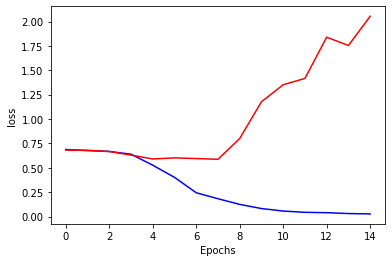

In [16]:
# Visualization of training process and loss function 
plt.plot(history[0]["loss"], color="b")
plt.plot(history[0]["val_loss"], color="r")
plt.ylabel("loss")

plt.xlabel("Epochs")
plt.show()

In [1]:
#### Our model performs well until 4 epochs where it starts overfitting. Best accuracy is 74.7% with 